In [1]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
import numpy as np
import pandas as pd
from stellargraph import StellarGraph
from stellargraph.data import EdgeSplitter
import multiprocessing
from sklearn.model_selection import train_test_split
import pickle

%matplotlib inline

2021-12-05 18:29:25.825028: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-05 18:29:25.829365: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-05 18:29:25.829665: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-05 18:29:25.830114: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [2]:
# Read the relations from pickle as DF and stellarGraph

with open('relation.pkl', 'rb') as filehandle:
        load_ke_list = pickle.load(filehandle)

df = pd.DataFrame(load_ke_list, columns=['source', 'target'])
df[['source','target']] = df[['source','target']].astype(str)
graph = StellarGraph(edges=df)
print(graph.info())

StellarGraph: Undirected multigraph
 Nodes: 211, Edges: 1317

 Node types:
  default: [211]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [1317]
        Weights: all 1 (default)
        Features: none


## Split the data into train/val/test groups and for node embeddings

* Node Embeddings Graph: graph_embeddings
* Training Set: examples_train (except graph_embeddings)
* Test Set for models: examples_model_selection
* Test Graph: graph_test
* Test Set: examples_test

###  Test Graph

*EdgeSplitter* is used to produce:

* Test Graph
* Test set

In [3]:
edge_splitter_test = EdgeSplitter(graph)

graph_test, examples_test, labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global"
)

print(graph_test.info())

** Sampled 131 positive and 131 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 211, Edges: 1186

 Node types:
  default: [211]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [1186]
        Weights: all 1 (default)
        Features: none


### Train Graph

*EdgeSplitter* on the Test Graph and Test/Train set:

* Train Graph
* Training Set
* Test Set for model selection


In [4]:
# Do the same process to compute a training subset from within the test graph
edge_splitter_train = EdgeSplitter(graph_test, graph)
graph_train, examples, labels = edge_splitter_train.train_test_split(
    p=0.1, method="global"
)
(
    examples_train,
    examples_model_selection,
    labels_train,
    labels_model_selection,
) = train_test_split(examples, labels, train_size=0.75, test_size=0.25)

print(graph_train.info())

** Sampled 118 positive and 118 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 211, Edges: 1068

 Node types:
  default: [211]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [1068]
        Weights: all 1 (default)
        Features: none


## Node2Vec

Node2Vec is used to run random walks on the graph. And a following Word2Vec model is trained to predict the sentence.

In [7]:
p = 1.0
q = 1.0
dimensions = 128
num_walks = 10
walk_length = 80
window_size = 10
num_iter = 1
workers = multiprocessing.cpu_count()
print(workers) # 24 thread are using to do the random walk

24


In [8]:
from stellargraph.data import BiasedRandomWalk
from gensim.models import Word2Vec


def node2vec_embedding(graph, name):
    rw = BiasedRandomWalk(graph)
    walks = rw.run(graph.nodes(), n=num_walks, length=walk_length, p=p, q=q)
    print(f"Number of random walks for '{name}': {len(walks)}")

    model = Word2Vec(
        walks,
        window=window_size,
        min_count=0,
        sg=1,
        workers=workers,
    )

    def get_embedding(u):
        return model.wv[u]

    return get_embedding

In [9]:
embedding_train = node2vec_embedding(graph_train, "Train Graph")

Number of random walks for 'Train Graph': 2110


## Train and Evaluate

In [12]:
from sklearn.metrics import roc_auc_score #ROC is used as metric
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV

In [14]:
# link embeddings
def link_examples_to_features(link_examples, transform_node, binary_operator):
    return [binary_operator(transform_node(src), transform_node(dst)) for src, dst in link_examples]


# training clf
def train_model(link_examples, link_labels, get_embedding, binary_operator):
    clf = link_prediction_classifier()
    link_features = link_examples_to_features(
        link_examples, get_embedding, binary_operator
    )
    clf.fit(link_features, link_labels)
    return clf

# LR are used as clf.
def classifier(max_iter=2000):
    lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=max_iter)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])


# evaluation as CV
def evaluate_prediction(clf, link_examples_test, link_labels_test, get_embedding, binary_operator):
    link_features_test = link_examples_to_features(
        link_examples_test, get_embedding, binary_operator
    )
    score = evaluate_roc_auc(clf, link_features_test, link_labels_test)
    return score


def evaluate_roc_auc(clf, link_features, link_labels):
    predicted = clf.predict_proba(link_features)
    positive_column = list(clf.classes_).index(1)
    return roc_auc_score(link_labels, predicted[:, positive_column])

We select 3 operators.

In [28]:
def l1(u, v):
    return np.abs(u - v)


def l2(u, v):
    return (u - v)*(u - v)


def avg(u, v):
    return (u + v)/2.0


def run_prediction(operator):
    clf = train_link_prediction_model(
        examples_train, labels_train, embedding_train, operator
    )
    score = evaluate_link_prediction_model(
        clf,examples_model_selection,labels_model_selection,embedding_train,operator,
    )
    return {
        "classifier": clf,
        "operator": operator,
        "score": score,
    }


operators = [l1, l2, avg]

In [29]:
results = [run_prediction(op) for op in operators]
best = max(results, key=lambda result: result["score"])

print(f"Best result from '{best['operator'].__name__}'")

pd.DataFrame(
    [(result["operator"].__name__, result["score"]) for result in results],
    columns=("name", "ROC AUC score"),
).set_index("name")

Best result from 'l1'


,ROC AUC score
name,
l1,0.974713
l2,0.974713
avg,0.734483


### Evaluate on test set

In [30]:
embedding_test = node2vec_embedding(graph_test, "Test Graph")

Number of random walks for 'Test Graph': 2110


In [33]:
test_score = evaluate_prediction(
    best["classifier"],
    examples_test,
    labels_test,
    embedding_test,
    best["operator"],
)
print(
    f"ROC AUC score on test set using '{best['operator'].__name__}': {test_score}"
)

ROC AUC score on test set using 'l1': 0.9884039391643844


### Visualization of link embeddings
Principle components analysis is used to descrease the dimension of the original link graph.

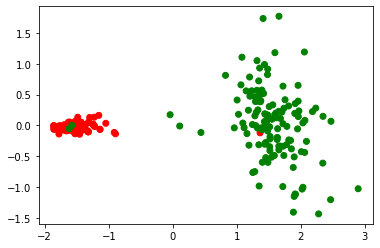

In [43]:
# Calculate edge features for test data
link_features = link_examples_to_features(
    examples_test, embedding_test, best["operator"]
)

pca = PCA(n_components=2)
X_trans = pca.fit_transform(link_features)

# plot the 2-dimensional points
plt.figure()
plt.scatter(
    X_trans[:, 0],
    X_trans[:, 1],
    c=np.where(labels_test == 1, "r", "g"),
)